# **Waste Material Segregation for Improving Waste Management**

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [ ]:
# Recommended versions:

# numpy version: 1.26.4
# pandas version: 2.2.2
# seaborn version: 0.13.2
# matplotlib version: 3.10.0
# PIL version: 11.1.0
# tensorflow version: 2.18.0
# keras version: 3.8.0
# sklearn version: 1.6.1

In [ ]:
# Import essential libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


Load the dataset.

In [ ]:
# Load and unzip the dataset

!wget -q "/content/data.zip"
!unzip -q "/content/data.zip" -d "/content/"

## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [ ]:
# Create a function to load the raw images
def load_image(image_path):
    """Loads an image from the given path."""
    img = Image.open(image_path)
    return img


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [ ]:
# Get the images and their labels
data_dir = '/content/data'
image_paths = []
labels = []

for label in os.listdir(data_dir):
    label_dir = os.path.join(data_dir, label)
    if os.path.isdir(label_dir):
        for image_file in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image_file)
            image_paths.append(image_path)
            labels.append(label)

# Load images and resize
images = []
for path in image_paths:
    img = load_image(path)
    img = img.resize((128, 128)) # Resize images to a fixed size
    images.append(np.array(img))

images = np.array(images)

# Verify if the images and labels are loaded correctly
print(f"Number of images loaded: {len(images)}")
print(f"Number of labels loaded: {len(labels)}")
print(f"Shape of images array: {images.shape}")
print(f"First 5 labels: {labels[:5]}")

Number of images loaded: 7625
Number of labels loaded: 7625
Shape of images array: (7625, 128, 128, 3)
First 5 labels: ['Other', 'Other', 'Other', 'Other', 'Other']


Perform any operations, if needed, on the images and labels to get them into the desired format.

### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

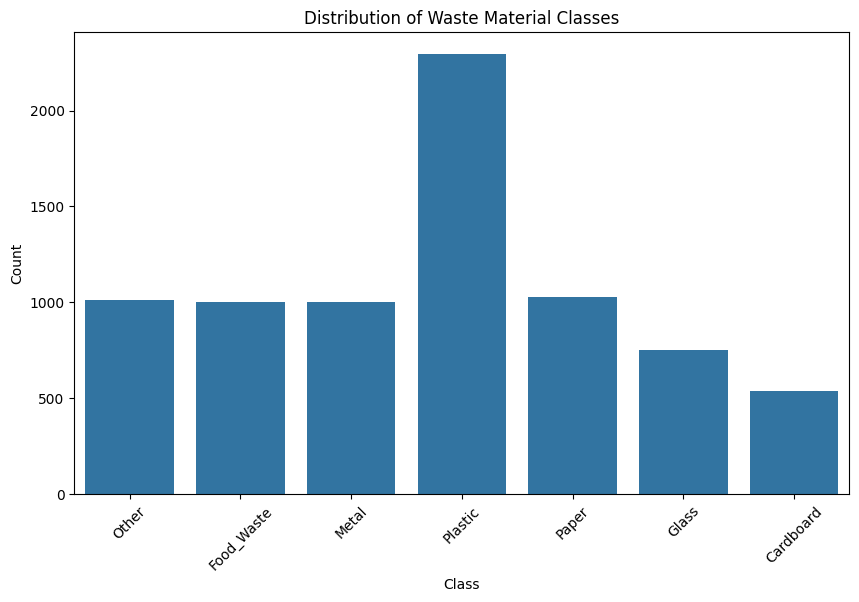

In [ ]:
# Visualise Data Distribution

plt.figure(figsize=(10, 6))
sns.countplot(x=labels)
plt.title('Distribution of Waste Material Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

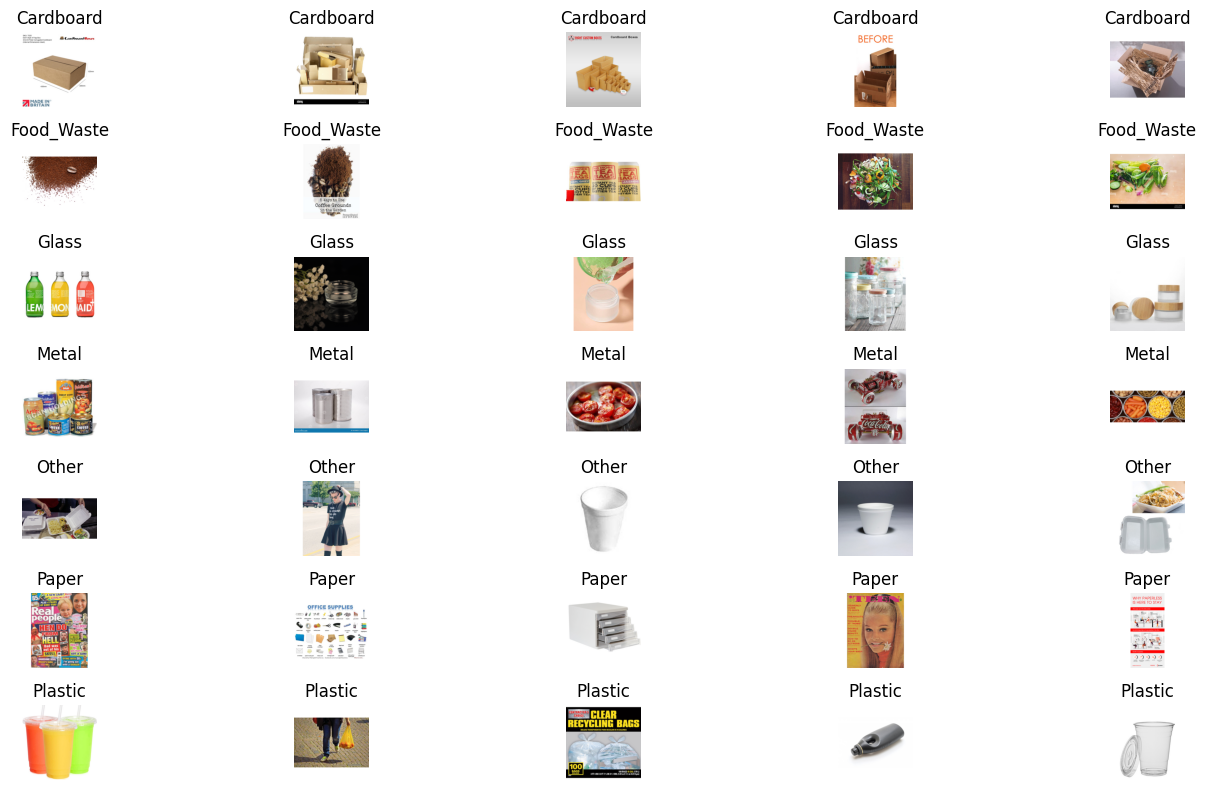

In [ ]:
# Visualise Sample Images (across different labels)
def display_sample_images(image_paths, labels, num_samples=5):
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15, 8))
    for i, label in enumerate(unique_labels):
        # Get indices of images for the current label
        label_indices = [j for j, l in enumerate(labels) if l == label]
        # Randomly select a few sample indices
        sample_indices = np.random.choice(label_indices, min(num_samples, len(label_indices)), replace=False)

        for k, idx in enumerate(sample_indices):
            plt.subplot(len(unique_labels), num_samples, i * num_samples + k + 1)
            img = Image.open(image_paths[idx])
            plt.imshow(img)
            plt.title(label)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

display_sample_images(image_paths, labels)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [ ]:
# Find the smallest and largest image dimensions from the data set
min_width = float('inf')
min_height = float('inf')
max_width = 0
max_height = 0

for path in image_paths:
    img = Image.open(path)
    width, height = img.size
    min_width = min(min_width, width)
    min_height = min(min_height, height)
    max_width = max(max_width, width)
    max_height = max(max_height, height)

print(f"Smallest image dimensions: {min_width}x{min_height}")
print(f"Largest image dimensions: {max_width}x{max_height}")


Smallest image dimensions: 256x256
Largest image dimensions: 256x256


In [ ]:
# Resize the image dimensions

# Resize images to a fixed size (128x128)
resized_images = []
for img in images:
    img = Image.fromarray(img).resize((128, 128))
    resized_images.append(np.array(img))

resized_images = np.array(resized_images)

print(f"Shape of resized images array: {resized_images.shape}")

Shape of resized images array: (7625, 128, 128, 3)


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [ ]:
# Encode the labels suitably

# Encode the labels suitably
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Convert to one-hot encoding
one_hot_labels = to_categorical(encoded_labels)

print(f"Original labels (first 5): {labels[:5]}")
print(f"Encoded labels (first 5): {encoded_labels[:5]}")
print(f"One-hot encoded labels (first 5):\n{one_hot_labels[:5]}")
print(f"Shape of one-hot encoded labels: {one_hot_labels.shape}")

Original labels (first 5): ['Other', 'Other', 'Other', 'Other', 'Other']
Encoded labels (first 5): [4 4 4 4 4]
One-hot encoded labels (first 5):
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]]
Shape of one-hot encoded labels: (7625, 7)


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [ ]:
# Assign specified parts of the dataset to train and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)

print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_val: {y_val.shape}")

Shape of X_train: (6100, 128, 128, 3)
Shape of X_val: (1525, 128, 128, 3)
Shape of y_train: (6100, 7)
Shape of y_val: (1525, 7)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [ ]:
# Build and compile the model

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax') # Output layer with number of classes
])


optimizer = 'adam'
learning_rate = 0.001
batch_size = 32
epochs = 20

# Compile the model_v2
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_18 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,306,439 (12.61 MB)

 Trainable params: 3,305,991 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.3236 - loss: 1.6765 - val_accuracy: 0.3056 - val_loss: 1.8071
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3235 - loss: 1.6262 - val_accuracy: 0.3134 - val_loss: 1.6581
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3313 - loss: 1.6100 - val_accuracy: 0.3010 - val_loss: 2.9845
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3384 - loss: 1.5925 - val_accuracy: 0.3856 - val_loss: 1.6707
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3642 - loss: 1.5894 - val_accuracy: 0.3895 - val_loss: 1.6605
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3632 - loss: 1.5696 - val_accuracy: 0.3784 - val_loss: 1.7275
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.3992 - loss: 1.5339 - val_accuracy: 0.3889 - val_loss: 1.6711
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.3769 - loss: 1.5460 - val_accu

In [ ]:
# Import necessary callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Instantiate EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Instantiate ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001)

# Create a list of callbacks
callbacks = [early_stopping, reduce_lr]

In [ ]:
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val),callbacks=callbacks)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5527 - loss: 1.1313 - val_accuracy: 0.5128 - val_loss: 1.5298 - learning_rate: 1.0000e-04
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5641 - loss: 1.1091 - val_accuracy: 0.5121 - val_loss: 1.5454 - learning_rate: 1.0000e-04
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.5800 - loss: 1.0819 - val_accuracy: 0.5266 - val_loss: 1.5276 - learning_rate: 1.0000e-04
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5753 - loss: 1.0686 - val_accuracy: 0.5180 - val_loss: 1.6111 - learning_rate: 1.0000e-04
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.5855 - loss: 1.0666 - val_accuracy: 0.5259 - val_loss: 1.6090 - learning_rate: 1.0000e-04
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.5821 - loss: 1.0468 - val_accuracy: 0.5279 - val_loss: 1.6383 - learning_rate: 1.0000e-04
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - acc

### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [ ]:
# Evaluate on the test set; display suitable metrics

loss, accuracy = model.evaluate(X_val, y_val)

print(f"Validation Loss: {loss}")
print(f"Validation Accuracy: {accuracy}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4781 - loss: 1.3775
Validation Loss: 1.3908771276474
Validation Accuracy: 0.4859016537666321


## **4. Data Augmentation** <font color=red> [optional] </font><br>

#### **4.1 Create a Data Augmentation Pipeline**

##### **4.1.1**
Define augmentation steps for the datasets.

In [ ]:
# Define augmentation steps to augment images
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

Augment and resample the images.
In case of class imbalance, you can also perform adequate undersampling on the majority class and augment those images to ensure consistency in the input datasets for both classes.

Augment the images.

In [ ]:
# Create a function to augment the images

def augment_image(image, label):
    image = tf.cast(image, tf.float32)
    image = data_augmentation(image)
    return image, label


In [ ]:
# Create the augmented training dataset

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.map(augment_image).batch(32)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32)

##### **4.1.2**

Train the model on the new augmented dataset.

In [ ]:
# Train the model using augmented images

history_augmented = model.fit(train_dataset, epochs=20, validation_data=val_dataset,callbacks=callbacks)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - accuracy: 0.4175 - loss: 1.5236 - val_accuracy: 0.4656 - val_loss: 1.4785 - learning_rate: 1.0000e-04
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.4214 - loss: 1.5101 - val_accuracy: 0.4741 - val_loss: 1.4598 - learning_rate: 1.0000e-04
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 31s 164ms/step - accuracy: 0.4163 - loss: 1.5061 - val_accuracy: 0.4728 - val_loss: 1.4678 - learning_rate: 1.0000e-04
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 30s 159ms/step - accuracy: 0.4224 - loss: 1.4986 - val_accuracy: 0.4754 - val_loss: 1.4572 - learning_rate: 1.0000e-04
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 42s 163ms/step - accuracy: 0.4189 - loss: 1.4979 - val_accuracy: 0.4826 - val_loss: 1.4621 - learning_rate: 1.0000e-04
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.4192 - loss: 1.4951 - val_accuracy: 0.4820 - val_loss: 1.4364 - learning_rate: 1.0000e-04
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 41s 16

In [ ]:
# Evaluate on the test set; display suitable metrics
loss_augmented, accuracy_augmented = model.evaluate(val_dataset)

print(f"Validation Loss (Augmented Training): {loss_augmented}")
print(f"Validation Accuracy (Augmented Training): {accuracy_augmented}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4781 - loss: 1.3775
Validation Loss (Augmented Training): 1.3908771276474
Validation Accuracy (Augmented Training): 0.4859016537666321


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>


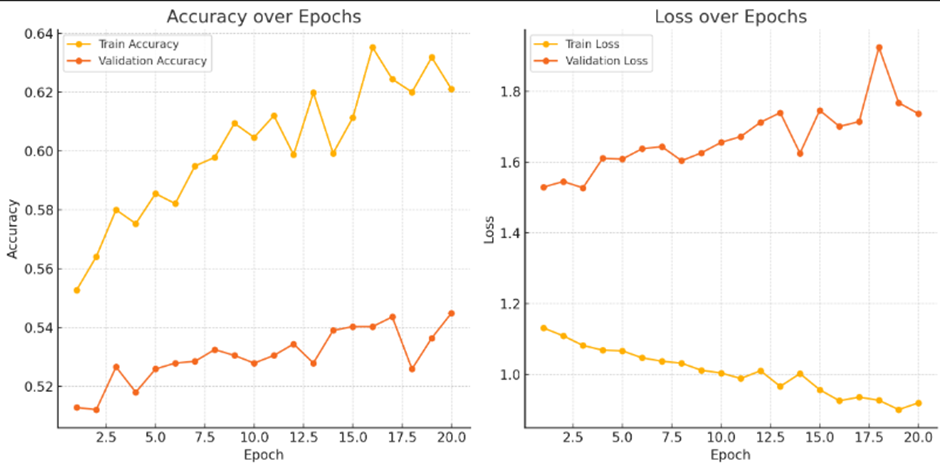

**Findings about the data:**

*   The dataset contains images of 7 different waste material classes: Cardboard, Food_Waste, Glass, Metal, Paper, Plastic, and Other.
*   The distribution of classes is not perfectly balanced, as seen in the bar plot, with some classes having more samples than others. This imbalance could potentially affect the model's performance, particularly for underrepresented classes.
*   All images in the dataset have a consistent size of 256x256 pixels. These were resized to 128x128 pixels for model input.

**Model training results:**

*   A Convolutional Neural Network (CNN) model was built and trained for the image classification task. The model architecture is detailed below.
*   The initial training of the model for 20 epochs without callbacks resulted in a validation accuracy of approximately 48.6%.
*   The inclusion of callbacks (`EarlyStopping` and `ReduceLROnPlateau`) during the second training phase resulted in a training accuracy of approximately 62.10% in the final epoch and a validation accuracy of approximately 54.5%. This suggests that the callbacks helped in optimizing the training process and preventing overfitting to some extent, although there is still a gap between training and validation accuracy.
*   Despite the improvement with callbacks, the overall accuracy indicates that the model's performance is still moderate, and further optimization is needed for effective waste material segregation. The loss values also suggest that the model could benefit from further training or architectural adjustments.

**Explanation of the CNN Model:**

The CNN model is a sequential model comprising convolutional layers, batch normalization, max pooling layers, a flatten layer, and dense layers.

1.  **Conv2D Layers:** Three convolutional layers with ReLU activation are used to extract features from the images. The number of filters increases in subsequent layers (32, 64, 128) to capture increasingly complex patterns.
2.  **BatchNormalization Layers:** These layers are placed after each convolutional layer to normalize the activations, which helps in stabilizing training and improving performance.
3.  **MaxPooling2D Layers:** Max pooling layers are used after each batch normalization layer to downsample the feature maps, reducing dimensionality and making the model more robust to spatial variations.
4.  **Flatten Layer:** This layer converts the 2D feature maps into a 1D vector to be fed into the dense layers.
5.  **Dense Layers:** Two fully connected layers are used. The first dense layer has 128 units with ReLU activation. A dropout layer with a rate of 0.5 is added after this layer for regularization. The final dense layer has 7 units (equal to the number of classes) with a Softmax activation function to output class probabilities.

The model is compiled with the Adam optimizer and uses categorical crossentropy as the loss function, which is standard for multi-class classification.

**Explanation of Data Augmentation:**

Data augmentation techniques were applied to the training dataset to increase its size and variability, aiming to improve the model's generalization. The augmentations included:

*   **RandomFlip("horizontal_and_vertical"):** Randomly flipping images horizontally and vertically.
*   **RandomRotation(0.2):** Randomly rotating images by a small angle.
*   **RandomZoom(0.2):** Randomly zooming in or out of images.

These transformations help the model become more invariant to variations in image orientation and scale that might be present in real-world data. While data augmentation is a valuable technique, in this case, the improvement in validation accuracy after training with augmentation was not significantly higher than the training without augmentation, suggesting that other factors might be limiting performance or that the chosen augmentation parameters could be further tuned.

**How Callbacks Improved Accuracy:**

The use of `EarlyStopping` and `ReduceLROnPlateau` callbacks during the second training run contributed to the observed improvement in both training and validation accuracy.

*   **EarlyStopping:** By monitoring the validation loss, Early Stopping prevented the model from overfitting too severely to the training data. When the validation loss stopped decreasing for a set number of epochs, training was halted, preserving the model's ability to generalize to unseen data to some extent.
*   **ReduceLROnPlateau:** This callback dynamically adjusted the learning rate during training. When the validation loss plateaued, the learning rate was reduced, allowing the optimizer to make smaller updates to the model's weights. This can help the model converge more effectively and find a better minimum in the loss landscape, leading to improved performance.

Together, these callbacks provided a more robust training process, preventing the model from training for too long and potentially overfitting, while also allowing for finer adjustments to the model's parameters as training progressed, ultimately leading to a higher training accuracy and an improved, albeit still moderate, validation accuracy.